In [79]:
#import needed libraries
import pymc3 as pm
import scipy.stats as stats
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt

In [84]:
#get datestamp and date of run
import time
## 12 hour format ##
datestamp = (time.strftime("%m/%d/%Y %H:%M:%S"))
date = time.strftime("%m%d%y")

#create ordered dictionaries with needed values
import collections as col

In [95]:
#now without dividing by ads or no
dic3= col.OrderedDict()
dic3['run_at'] = datestamp
dic3['dic_name'] = 'XXXX' #create this with publisher name and device type
dic3['device'] = 'desktop'
dic3['cu'] = 19318 #control uniques
dic3['cc'] = 198 #control clicks
dic3['tu'] = 19070 #treatment uniques
dic3['tc'] = 188 #treatment clicks

In [96]:
def create_obs_vars(dic):

    #for ordered dictionaries
    import collections as col
    
    #placebo group
    global control_obs
    control_obs = np.hstack(([0]*(dic['cu']-dic['cc']),[1]*dic['cc']))    
    
    #test_group 
    global test_obs
    test_obs = np.hstack(([0]*(dic['tu']-dic['tc']),[1]*dic['tc']))
    
    #calc placebo conv rate
    global control_conv
    control_conv = float(dic['cc'])/float(dic['cu'])
    
    #calc test conv rate
    global test_conv
    test_conv = float(dic['tc'])/float(dic['tu'])
    
    #get the dictionary name
    global dic_nam
    dic_nam = dic['dic_name']
    
    #create csv dictionary
    global csv_dic
    csv_dic = {} #col.OrderedDict()
    csv_dic.update(dic)
    
    return control_obs, test_obs, control_conv, dic_nam, csv_dic, test_conv

In [97]:
#create important globals
create_obs_vars(dic3)

(array([0, 0, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 1]),
 0.010249508230665701,
 'HolidayCheckD',
 {'cc': 198,
  'cu': 19318,
  'device': 'desktop',
  'dic_name': 'HolidayCheckD',
  'run_at': '05/08/2017 17:48:37',
  'tc': 188,
  'tu': 19070},
 0.009858416360776088)

In [98]:
#set up the pymc3 model. 
with pm.Model() as model:
    
    #generate the needed variables here divide up the globals and the locals in the future
    
    #prior as uniform stochastic variable
    #stronger beliefs could lead to different priors
    p_test = pm.Uniform("p_test", 0, 1)
    p_control = pm.Uniform("p_control", 0, 1)
    
    #deterministic delta variable, our unknown of interest
    #deterministic is not based on a distribution
    delta = pm.Deterministic("delta", p_test - p_control)
    
    # Set of observations
    # Bernoulli stochastic variables generated via our observed values
    obs_A = pm.Bernoulli("obs_A", p_test, observed=test_obs)
    obs_B = pm.Bernoulli("obs_B", p_control, observed=control_obs)

    #monte carlo simulation, last step of model, this part takes the longest
    #metropolis-hastings algo, gets sequence of random variables from prob. dist.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace = trace[10000:]

C:\Users\tnelson\Anaconda3\lib\site-packages\theano\tensor\basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:06<00:00, 3095.79it/s]


In [99]:
# generated likelihood, prior, and posterior distributions as arrays of values
p_test_samples = burned_trace["p_test"]
p_control_samples = burned_trace["p_control"]
delta_samples = burned_trace["delta"]

In [100]:
#put key results into the csv dictionary

#record all the stats here and save as csv
#add the absolute line for 2%
target_cann = -0.02
abs_target = (control_conv)*target_cann
sim_avg = round(np.mean(delta_samples),6)
prob_cann = round(np.mean(delta_samples < abs_target)*100,2)
prob_no_cann = round(np.mean(delta_samples > abs_target)*100,2)
conf_int_l = str(np.percentile(delta_samples,5))
conf_int_h = str(np.percentile(delta_samples,95))
conf_int_rel_l = str(round(100*(np.percentile(delta_samples,5)/control_conv),2))
conf_int_rel_h = str(round(100*(np.percentile(delta_samples,95)/control_conv),2))

#add to csv dictionary
csv_dic['conrol_conv'] = round(control_conv,4)
csv_dic['treatment_conv'] = round(test_conv,4)
csv_dic['avg_diff'] = round(((control_conv-(float(csv_dic['tc'])/float(csv_dic['tu'])))/control_conv)*100,3)
csv_dic['target_cann'] = target_cann
#csv_dic['sim_avg'] = sim_avg
csv_dic['prob_cann'] = prob_cann
csv_dic['prob_no_cann'] = prob_no_cann
csv_dic['conf_int_l'] = conf_int_l
csv_dic['conf_int_h'] = conf_int_h
csv_dic['conf_int_rel_l'] = conf_int_rel_l
csv_dic['conf_int_rel_h'] = conf_int_rel_h

print(csv_dic)

{'run_at': '05/08/2017 17:48:37', 'dic_name': 'HolidayCheckD', 'device': 'desktop', 'cu': 19318, 'cc': 198, 'tu': 19070, 'tc': 188, 'conrol_conv': 0.0102, 'treatment_conv': 0.0099, 'avg_diff': 3.816, 'target_cann': -0.02, 'prob_cann': 57.600000000000001, 'prob_no_cann': 42.399999999999999, 'conf_int_l': '-0.00201620457817', 'conf_int_h': '0.00123863542116', 'conf_int_rel_l': '-19.67', 'conf_int_rel_h': '12.08'}


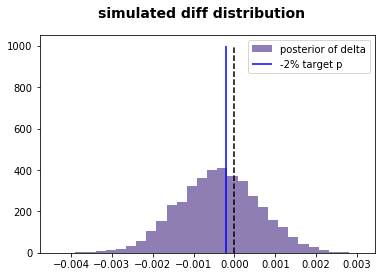

average difference -0.000395231518855 over control_conv:-0.0385610226325
Probability of cannibalization > 2% is 57.6%
95% confidence interval (-0.00201620457817, 0.00123863542116)
95% confident effect range (-19.67%,12.08%)


In [102]:
#visualize the delta dist. and save as an image

#view iplots inline
%matplotlib inline  

#create the plot figure / plot container
fig = plt.figure()
fig.suptitle('simulated delta distribution', fontsize=14, fontweight='bold')
fig.suptitle('simulated diff distribution', fontsize=14, fontweight='bold')

#create and plot the subplot
ax = plt.subplot(111)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of delta", color="#7A68A6", normed=True)
plt.vlines(0, 0, 1000, color="black", linestyle="--") #, label="neg-pos division")
plt.vlines(abs_target, 0, 1000, color="blue", linestyle="-", label="-2% target p")
plt.legend(loc="upper right");
plt.show()

#save the plot as a file
fig.savefig(file_name+".png",bbox_inches='tight')

#print out key metrics
abs_two = (control_conv)*.02*-1
print ("average difference " +str(np.mean(delta_samples))+ " over control_conv:"+ str(np.mean(delta_samples)/control_conv))
#print "Probability of cannibalization is "+str(np.mean(delta_samples < 0)*100)+"%"
#print "Probability of no cannibalization is "+str(np.mean(delta_samples > 0)*100)+"%"
print ("Probability of cannibalization > 2% is "+str(np.mean(delta_samples < abs_two)*100)+"%")
print ("95% confidence interval ("+str(np.percentile(delta_samples,5))+", "+str(np.percentile(delta_samples,95))+")")
print ("95% confident effect range (" +str(round(100*(np.percentile(delta_samples,5)/control_conv),2))+"%,"+str(round(100*(np.percentile(delta_samples,95)/control_conv),2))+"%)")


In [103]:
#final counts
print (str(csv_dic['cu'])+" control uniques")
print (str(csv_dic['cc'])+" control conversions")
print (str(round(control_conv*100,2))+"% control conversion")
print (str(csv_dic['tu'])+" treatment uniques")
print (str(csv_dic['tc'])+" treatment conversions")
print (str(round((float(csv_dic['tc'])/float(csv_dic['tu']))*100,2))+"% test conversion")
print (str(((control_conv-(float(csv_dic['tc'])/float(csv_dic['tu'])))/control_conv)*100)+"% avg diff")

19318 control uniques
198 control conversions
1.02% control conversion
19070 treatment uniques
188 treatment conversions
0.99% test conversion
3.815713506327043% avg diff


In [ ]:
#put everything into S3 bucket